In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings('ignore')


# process load time data
systems = ['baseline', 'dlcache']
# compute_time = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
compute_time = [0.4, 0.8, 1.2, 1.6, 2.0, 2.4]
batch_size = [256, 512, 1024, 2048]
repeats = 4
data = []

for s in systems:
    for r in range(repeats):
        for b in batch_size:
            for c in compute_time:
                try:
                    dir = "{}/data/run{}/{}/{}".format(s, r, c, b)
                    load_time = np.load('{}/load_time.npy'.format(dir))[0]
                    if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                        avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                        avg_cache_usage = np.mean(avg_cache_usage, dtype=int)
                        cache_hits = 0
                        for ch in glob.glob("{}/cache_hits*".format(dir)):
                            cache_hits += np.load(ch)
                        cache_hit_rate = cache_hits / (b * 100)
                    else:
                        avg_cache_usage = 0
                        cache_hit_rate = 0

                    data.append([s, c, b, load_time, avg_cache_usage, cache_hit_rate])
                except:
                    pass

data = pd.DataFrame(data, columns=['system', 'compute_time', 'batch_size', 'load_time', 'avg_cache_usage', 'cache_hit_rate'])
data.sort_values(by='compute_time', inplace=True)
data.to_csv('data.csv', index=False)

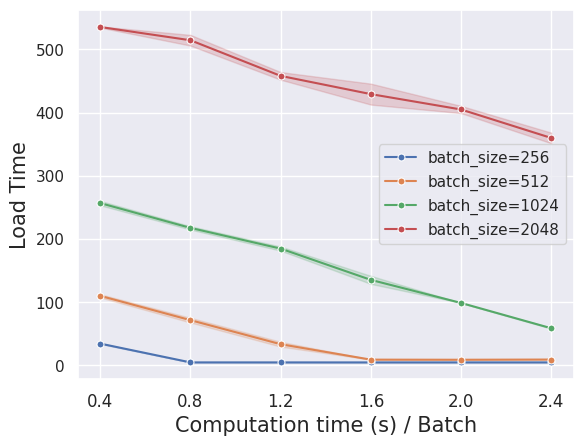

In [12]:
compute_time = data['compute_time'].unique().tolist()
sns.set(style='darkgrid',)
# sns.set(rc={'figure.figsize':(5, 3)})

for b in batch_size:
    slices = []
    for s in systems[:1]:
        slice = data[(data['system']==s) & (data['batch_size']==b)].sort_values(by='compute_time')
        compute_time_ticks = []
        for ct in slice['compute_time']:
            compute_time_ticks.append(compute_time.index(ct))
        slice['compute_time'] = compute_time_ticks
        sns.lineplot(x='compute_time', y='load_time', data=slice, label='batch_size={}'.format(b), marker='.', markersize=10)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Load Time', fontsize = 15)
plt.legend()
plt.show()

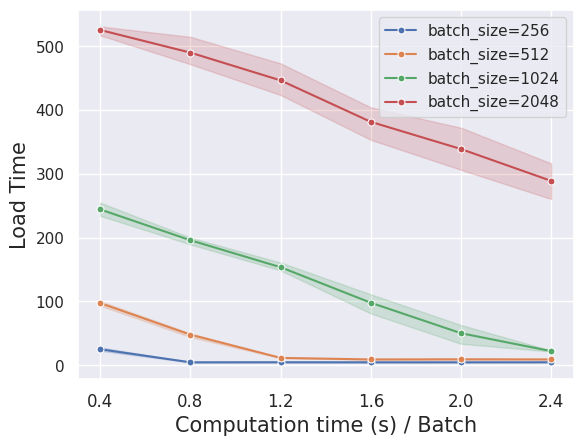

In [13]:
compute_time = data['compute_time'].unique().tolist()
sns.set(style='darkgrid',)
# sns.set(rc={'figure.figsize':(5, 3)})


for b in batch_size:
    slices = []
    for s in systems[1:]:
        slice = data[(data['system']==s) & (data['batch_size']==b)].sort_values(by='compute_time')
        compute_time_ticks = []
        for ct in slice['compute_time']:
            compute_time_ticks.append(compute_time.index(ct))
        slice['compute_time'] = compute_time_ticks
        sns.lineplot(x='compute_time', y='load_time', data=slice, label='batch_size={}'.format(b), marker='.', markersize=10)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Load Time', fontsize = 15)
plt.legend()
plt.show()

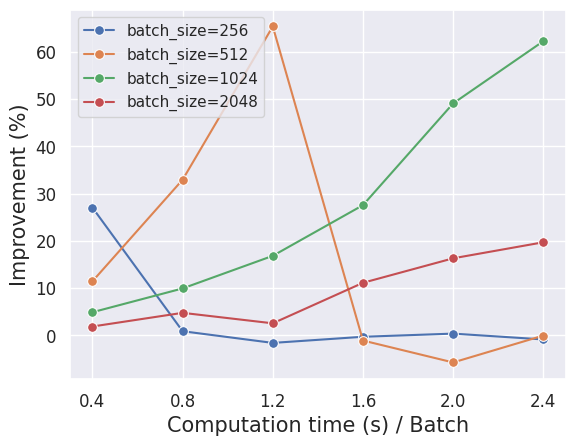

In [14]:
for b in batch_size:
    slices = []
    for s in systems:
        slice = data[(data['system']==s) & (data['batch_size']==b)].sort_values(by='compute_time')
        error = slice.groupby(by='compute_time').std().reset_index()
        slice = slice.groupby(by='compute_time').mean().reset_index()
        slices.append(slice['load_time'].values)
        
    imp = 100 * (slices[0] - slices[1])/slices[0]
    imp = pd.DataFrame([compute_time, imp]).T
    imp.columns = ['compute_time', 'improvement(%)']
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    imp['compute_time'] = compute_time_ticks
    sns.lineplot(x='compute_time', y='improvement(%)', data=imp, label='batch_size={}'.format(b), marker= '.', markersize=14)
    
plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Improvement (%)', fontsize = 15)
plt.legend()
plt.show()

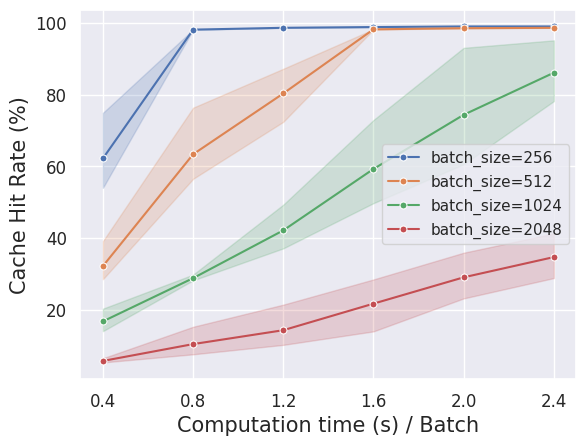

In [15]:

for b in batch_size:
    slice = data[(data['system']=='dlcache') & (data['batch_size']==b)].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    slice['cache_hit_rate'] *= 100.0
    if len(slice) > 0:
        sns.lineplot(x='compute_time', y='cache_hit_rate', data=slice, label='batch_size={}'.format(b), marker= '.', markersize=10)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Cache Hit Rate (%)', fontsize = 15)
plt.legend()
plt.show()

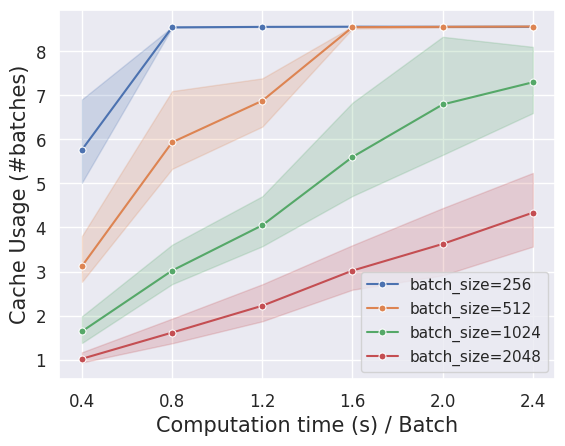

In [16]:

for b in batch_size:
    slice = data[(data['system']=='dlcache') & (data['batch_size']==b)].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    slice['cache_usage'] = slice['avg_cache_usage'] / b
    if len(slice) > 0:
        sns.lineplot(x='compute_time', y='cache_usage', data=slice, label='batch_size={}'.format(b), marker= '.', markersize=10)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Cache Usage (#batches)', fontsize = 15)
plt.legend()
plt.show()